Задача

Реализация модели прогнозирования средних цен и объемов потребления отдельных групп товаров. Горизонт прогнозирования – 3 месяца.

Основным источником информации являются наборы данных по целевым продуктовым группам за исторический период с начала 2019 года. Однако, для повышения точности прогнозирования возможно использовать для обучения модели дополнительные данные, например, об основных демографических показателях территорий.

Допустимо использовать социально-экономические данные из открытых источников с указанием источника.

Вам даны:

Дата-сет ФНС, содержащий сведения о ценах и объемах реализации 32 наименований продуктовых товаров, 4 видов ГСМ и потребительских корзин.

Каждая строка наблюдения – это данные по субъекту РФ за определенный день. Всего набор содержит 5 577 874 фактов наблюдений за 821 день по 86 регионам по 79 атрибутам за период с 1 января 2019 года по 31 марта 2021 года.

Уникальной комбинацией является комбинация полей: {date, region} или {date, oktmo}, или {date, akato}.

Формат решения:

Необходимо предсказать цены и объемы за период с 01.04.2021 по 30.06.2021 в разрезе регионов (см. файл test.csv).  Пример заполненного файла с решением, в котором все искомые значения нулевые, см. в файле sample_submission.csv.

 

Расчет метрики

1. Для каждого прогнозируемого показателя (столбца) рассчитывается его среднее значение v_mean j  и значение метрики MAE: v_mae j
2. Для каждого показателя вычисляется отношение

$ E j  = v_mae j  / v_mean j $

3. Рассчитывается среднее значение E среди всех столбцов 

$ E_mean = 1 / n * sum(E j ) $

4. Берется обратная величина и делится на константу 1000

$ score = 1 / (1000 * E_mean) $

In [43]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 115)
pd.set_option('display.max_rows', 100)

In [44]:
%%time
df_sample_submission = pd.read_csv('sample_submission.csv', encoding='utf-8')
df_test = pd.read_csv('test.csv', encoding='utf-8')
df_train = pd.read_csv('train.csv', sep=';', encoding='utf-8')

Wall time: 1.16 s


In [45]:
# Формат данных:

# date – Дата наблюдения, в формате ДД.ММ.ГГГГ
# region – Код региона в кодировке ФНС России
# okato  – ОКАТО региона РФ
# oktmo – ОКТМО региона РФ
# pasta  – макароны (средняя взвешенная цена), руб/кг
# legumes – бобовые,          руб/кг
# bread  – хлеб , руб/кг
# flour   – мука, руб/кг
# rice    – рис, руб/кг
# groats – другие крупы, руб/кг
# potatoes – картофель, руб/кг
# сucumbers_tomatoes – огурцы и помидоры, руб/кг
# vegetables – прочие овощи, руб/кг
# roots  – столовые корнеплоды, руб/кг
# сabbage – капуста, руб/кг
# fruit – фрукты, руб/кг
# sugar – сахар, руб/кг
# candy – конфеты, руб/кг
# biscuits – печенье, руб/кг
# mutton – баранина, руб/кг
# beef – говядина, руб/кг
# chicken – мясо птицы, руб/кг
# pork – свинина, руб/кг
# fish – рыба свеж, руб/кг
# herring – сельдь, руб/кг
# curd – творог, руб/кг
# sour_creame – сметана, руб/кг
# butter – масло сливочное, руб/кг
# milk_kefir – молоко кефир, руб/л
# cheese – сыр, руб/кг
# egg – яйца, руб/шт
# margarine – маргарин и другие жиры, руб/кг
# oil – масло раститительное, руб/л
# salt – соль, руб/кг
# spice –специи, руб/шт
# tea – чай, руб/шт
# CPI_1 – стоимость потребительской корзины для трудоспособных граждан, руб
# CPI_2 – стоимость потребительской корзины для пенсионеров, руб
# CPI_3 – стоимость потребительской корзины для детей до 18 лет, руб
# Pasta_value – макароны (объем проданной продукции), кг
# legumes_value – бобовые (объем проданной продукции), кг
# bread_value – хлеб (объем проданной продукции), кг
# flour_value – мука (объем проданной продукции), кг
# rice_value – рис (объем проданной продукции), кг
# groats_value – другие крупы (объем проданной продукции), кг
# potatoes_value – картофель (объем проданной продукции), кг
# сucumbers_tomatoes_value – огурцы и помидоры (объем проданной продукции), кг
# vegetables_value – прочие овощи (объем проданной продукции), кг
# roots_value – столовые корнеплоды (объем проданной продукции), кг
# сabbage_value – капуста (объем проданной продукции), кг
# fruit_value – фрукты (объем проданной продукции), кг
# sugar_value – сахар (объем проданной продукции), кг
# candy_value – конфеты (объем проданной продукции), кг
# biscuits_value         – печенье (объем проданной продукции), кг
# mutton_value – баранина (объем проданной продукции), кг
# beef_value – говядина (объем проданной продукции), кг
# chicken_value         – мясо птицы(объем проданной продукции), кг
# pork_value – свинина (объем проданной продукции), кг
# fish_value – рыба свеж (объем проданной продукции), кг
# herring_value – сельдь (объем проданной продукции), кг
# curd_value – творог (объем проданной продукции), кг
# sour_creame_value – сметана (объем проданной продукции), кг
# butter_value – масло сливочное (объем проданной продукции), кг
# milk_kefir_value –молоко кефир (объем проданной продукции), л
# cheese_value – сыр (объем проданной продукции), кг
# egg_value – яйца (объем проданной продукции), шт
# margarine_value – маргарин и другие жиры (объем проданной продукции), кг
# oil_value – масло раститительное (объем проданной продукции), л
# salt_value – соль (объем проданной продукции)        , кг
# spice_value – специи (объем проданной продукции), шт
# tea_value – чай (объем проданной продукции), шт
# ai92 – бензин марки АИ-92, руб/литр
# ai95 – бензин марки АИ-95, руб/литр
# ai98 – бензин марки АИ-98, руб/литр
# dt – дизельное топливо, руб/литр
# ai92_value – бензин марки АИ-92 (объем проданной продукции), литр
# ai95_value – бензин марки АИ-95 (объем проданной продукции), литр
# ai98_value – бензин марки АИ-98 (объем проданной продукции), литр
# dt_value – дизельное топливо (объем проданной продукции), литр

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60193 entries, 0 to 60192
Data columns (total 79 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   region                    60193 non-null  int64 
 1   oktmo                     60193 non-null  int64 
 2   okato                     60193 non-null  int64 
 3   date                      60193 non-null  object
 4   pasta                     60193 non-null  object
 5   legumes                   60193 non-null  object
 6   bread                     60193 non-null  object
 7   flour                     60193 non-null  object
 8   rice                      60193 non-null  object
 9   groats                    60193 non-null  object
 10  potatoes                  60193 non-null  object
 11  сucumbers_tomatoes        60193 non-null  object
 12  vegetables                60193 non-null  object
 13  roots                     60193 non-null  object
 14  сabbage               

In [47]:
df_train['date'] = pd.to_datetime(df_train['date'],  format='%d.%m.%Y')
df_train['date'][0]

Timestamp('2021-03-31 00:00:00')

In [48]:
len(df_train['region'].value_counts())

84

In [49]:
df_train['pasta'][0]

'86,36'

In [50]:
df_sample_submission

region        oktmo        okato        date  pasta  legumes  bread  \
0         65  64000000000  64000000000  30.06.2021      0        0      0   
1         66  65000000000  65000000000  30.06.2021      0        0      0   
2         64  63000000000  63000000000  30.06.2021      0        0      0   
3         67  66000000000  66000000000  30.06.2021      0        0      0   
4         70  69000000000  69000000000  30.06.2021      0        0      0   
...      ...          ...          ...         ...    ...      ...    ...   
7730      43  33000000000  33000000000  01.04.2021      0        0      0   
7731      73  73000000000  73000000000  01.04.2021      0        0      0   
7732      74  75000000000  75000000000  01.04.2021      0        0      0   
7733      72  71000000000  71000000000  01.04.2021      0        0      0   
7734      75  76000000000  76000000000  01.04.2021      0        0      0   

      flour  rice  groats  potatoes  сucumbers_tomatoes  vegetables  roots  \
0         0     0       0         0                   0           0      0   
1         0     0       0         0                   0           0      0   
2         0     0       0         0                   0           0      0   
3         0     0       0         0                   0           0      0   
4         0     0       0         0                   0           0      0   
...     ...   ...     ...       ...                 ...         ...    ...   
7730      0     0       0         0                   0           0      0   
7731      0     0       0         0                   0           0      0   
7732      0     0       0         0                   0           0      0   
7733      0     0       0         0                   0           0      0   
7734      0     0       0         0                   0           0      0   

      сabbage  fruit  sugar  candy  biscuits  mutton  beef  chicken  pork  \
0           0      0      0      0         0       0     0        0     0   
1           0      0      0      0         0       0     0        0     0   
2           0      0      0      0         0       0     0        0     0   
3           0      0      0      0         0       0     0        0     0   
4           0      0      0      0         0       0     0        0     0   
...       ...    ...    ...    ...       ...     ...   ...      ...   ...   
7730        0      0      0      0         0       0     0        0     0   
7731        0      0      0      0         0       0     0        0     0   
7732        0      0      0      0         0       0     0        0     0   
7733        0      0      0      0         0       0     0        0     0   
7734        0      0      0      0         0       0     0        0     0   

      fish  herring  curd  sour_creame  butter  milk_kefir  cheese  egg  \
0        0        0     0            0       0           0       0    0   
1        0        0     0            0       0           0       0    0   
2        0        0     0            0       0           0       0    0   
3        0        0     0            0       0           0       0    0   
4        0        0     0            0       0           0       0    0   
...    ...      ...   ...          ...     ...         ...     ...  ...   
7730     0        0     0            0       0           0       0    0   
7731     0        0     0            0       0           0       0    0   
7732     0        0     0            0       0           0       0    0   
7733     0        0     0            0       0           0       0    0   
7734     0        0     0            0       0           0       0    0   

      margarine  oil  salt  spice  tea  cpi_1  cpi_2  cpi_3  pasta_value  \
0             0    0     0      0    0      0      0      0            0   
1             0    0     0      0    0      0      0      0            0   
2             0    0     0      0    0      0      0      0            0   
3             

In [51]:
df_sample_submission['date'] = pd.to_datetime(df_sample_submission['date'],  format='%d.%m.%Y')
df_sample_submission['date'][0]

Timestamp('2021-06-30 00:00:00')

In [52]:
print(df_sample_submission['date'].max())
print(df_sample_submission['date'].min())

2021-06-30 00:00:00
2021-04-01 00:00:00


In [53]:
print(df_train['date'].max())
print(df_train['date'].min())

2021-03-31 00:00:00
2019-04-23 00:00:00


In [54]:
df_test

region        oktmo        okato        date  pasta  legumes  bread  \
0         65  64000000000  64000000000  30.06.2021    NaN      NaN    NaN   
1         66  65000000000  65000000000  30.06.2021    NaN      NaN    NaN   
2         64  63000000000  63000000000  30.06.2021    NaN      NaN    NaN   
3         67  66000000000  66000000000  30.06.2021    NaN      NaN    NaN   
4         70  69000000000  69000000000  30.06.2021    NaN      NaN    NaN   
...      ...          ...          ...         ...    ...      ...    ...   
7730      43  33000000000  33000000000  01.04.2021    NaN      NaN    NaN   
7731      73  73000000000  73000000000  01.04.2021    NaN      NaN    NaN   
7732      74  75000000000  75000000000  01.04.2021    NaN      NaN    NaN   
7733      72  71000000000  71000000000  01.04.2021    NaN      NaN    NaN   
7734      75  76000000000  76000000000  01.04.2021    NaN      NaN    NaN   

      flour  rice  groats  potatoes  сucumbers_tomatoes  vegetables  roots  \
0       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
1       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
2       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
3       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
4       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
...     ...   ...     ...       ...                 ...         ...    ...   
7730    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7731    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7732    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7733    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7734    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   

      сabbage  fruit  sugar  candy  biscuits  mutton  beef  chicken  pork  \
0         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
1         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
2         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
3         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
4         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
...       ...    ...    ...    ...       ...     ...   ...      ...   ...   
7730      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7731      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7732      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7733      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7734      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   

      fish  herring  curd  sour_creame  butter  milk_kefir  cheese  egg  \
0      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
1      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
2      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
3      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
4      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
...    ...      ...   ...          ...     ...         ...     ...  ...   
7730   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7731   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7732   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7733   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7734   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   

      margarine  oil  salt  spice  tea  cpi_1  cpi_2  cpi_3  pasta_value  \
0           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
1           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
2           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
3           Na

In [55]:
len(df_sample_submission['region'].value_counts())

84

In [56]:
prosh_per = df_train[(df_train['date'] <= pd.Timestamp('2020-06-30 00:00:00')) &
                     (df_train['date'] >= pd.Timestamp('2020-04-01 00:00:00'))
                    ]

In [57]:
prosh_per['date'] = prosh_per['date'].apply(lambda x: str(x).replace('2020-','2021-'))
prosh_per['date'] = pd.to_datetime(prosh_per['date'],  format='%Y.%m.%d')
prosh_per[:5]

region        oktmo        okato       date  pasta legumes  bread  \
23290      55  52000000000  52000000000 2021-06-30  73,73   83,07  64,31   
23291      53  49000000000  49000000000 2021-06-30  80,33   94,76  74,74   
23292      54  50000000000  50000000000 2021-06-30  79,24   81,51  68,99   
23293      52  22000000000  22000000000 2021-06-30  82,02   85,15  68,12   
23294      31  14000000000  14000000000 2021-06-30  84,85   94,72  65,02   

       flour   rice groats potatoes сucumbers_tomatoes vegetables  roots  \
23290  28,89  84,04  57,74    48,84               85,7      30,68  49,71   
23291  35,58   87,9   61,9    41,33              99,69      37,14  54,63   
23292  30,57   85,9  55,18    50,44              88,52      30,45  53,87   
23293  33,69  71,37  57,57    36,96              96,02      42,65   54,3   
23294  35,65  83,19  60,45    40,41              87,63      34,33  48,62   

      сabbage  fruit  sugar   candy biscuits  mutton    beef chicken    pork  \
23290   25,88   96,5  31,23  267,23   157,77       0  312,24  155,65  275,36   
23291   28,33  101,2  29,66  289,86   157,85       0  470,99  146,41   229,1   
23292   23,07  103,2  33,33  299,79   164,89  344,57  316,19  166,89  264,99   
23293   24,07  105,9  30,82  281,65    146,7  429,41  374,19  152,22  246,82   
23294   22,74  103,2  30,38   299,3   163,02  225,79  322,68  144,84  255,18   

         fish herring    curd sour_creame  butter milk_kefir  cheese   egg  \
23290  284,98  242,66  258,26      183,31  407,11      53,67  512,67  5,04   
23291  320,91  214,26  277,99      186,11  558,94      50,58   478,6  4,37   
23292  257,63  210,57  262,21      137,47  464,22      56,07  511,92  4,96   
23293  357,29  291,21  221,67      186,56  483,86      54,84  466,53  4,66   
23294  330,54  224,39  245,12      169,12  488,88      51,38  495,23  4,79   

      margarine    oil   salt  spice    tea     cpi_1     cpi_2     cpi_3  \
23290     93,98  81,99  16,67  29,86   80,1  5 128,85  4 361,01  5 128,31   
23291    125,85  80,09   23,8     34  81,23  5 497,48  4 667,04  5 521,18   
23292     85,14  84,74  14,24  27,22  85,71  5 262,88  4 469,66  5 286,64   
23293    124,09  82,45  21,22  35,58   82,4  5 301,78  4 511,73  5 365,47   
23294    117,85  80,57  21,14   35,7  68,42  5 107,00  4 342,63  5 184,31   

      pasta_value legumes_value bread_value flour_value rice_value  \
23290   28 672,29      4 002,73   76 437,52   23 629,76   6 646,08   
23291   13 028,46      2 200,84   38 180,04    6 587,35   2 744,87   
23292   53 909,64      8 681,73  131 934,90   37 287,12  12 460,62   
23293   56 293,45     10 100,90  200 712,44   33 649,44  17 936,33   
23294   17 004,76      2 974,70  112 220,48   13 927,79   5 731,53   

      groats_value potatoes_value сucumbers_tomatoes_value vegetables_value  \
23290    15 559,93      23 539,65                27 908,81        13 322,76   
23291     6 440,79      22 689,03                25 267,05         6 702,96   
23292    74 927,09      47 996,43                74 281,55        28 416,39   
23293    37 148,91      84 706,50                95 366,72        27 887,44   
23294    12 783,12      54 016,60                40 137,09        13 930,72   

      roots_value сabbage_value fruit_value sugar_value candy_value  \
23290    9 106,89      9 629,22   48 232,10   76 276,73   15 431,55   
23291    7 157,68      6 405,17   30 015,90   33 585,62    5 682,86   
23292   19 193,11     18 824,70  101 283,40  126 886,63   21 755,59   
23293   28 634,39     34 061,72  125 384,80  134 011,40   27 979,65   
23294   14 237,46     12 784,89   51 401,80   49 164,15   12 208,44   

      biscuits_value mutton_value beef_value chicken_value pork_value  \
23290      19 646,94            0   1 603,40     54 619,79   7 300,64   
23291       7 439,98            0     393,08     26 565,21   5 216,64   
23292      34 112,44        177,2   5 798,37    104 958,11  19 825,49   
23293      34 381,28       241,84   3 527,78    130 318,75  35 49

In [58]:
prosh_per['date'] = prosh_per['date'].astype('str')
df_test['date'] = df_test['date'].astype('str')
prosh_per['date'] = prosh_per['date'].apply(lambda x: x.split('-')[2]+'.'+x.split('-')[1]+'.'+x.split('-')[0])
prosh_per[:5]

region        oktmo        okato        date  pasta legumes  bread  \
23290      55  52000000000  52000000000  30.06.2021  73,73   83,07  64,31   
23291      53  49000000000  49000000000  30.06.2021  80,33   94,76  74,74   
23292      54  50000000000  50000000000  30.06.2021  79,24   81,51  68,99   
23293      52  22000000000  22000000000  30.06.2021  82,02   85,15  68,12   
23294      31  14000000000  14000000000  30.06.2021  84,85   94,72  65,02   

       flour   rice groats potatoes сucumbers_tomatoes vegetables  roots  \
23290  28,89  84,04  57,74    48,84               85,7      30,68  49,71   
23291  35,58   87,9   61,9    41,33              99,69      37,14  54,63   
23292  30,57   85,9  55,18    50,44              88,52      30,45  53,87   
23293  33,69  71,37  57,57    36,96              96,02      42,65   54,3   
23294  35,65  83,19  60,45    40,41              87,63      34,33  48,62   

      сabbage  fruit  sugar   candy biscuits  mutton    beef chicken    pork  \
23290   25,88   96,5  31,23  267,23   157,77       0  312,24  155,65  275,36   
23291   28,33  101,2  29,66  289,86   157,85       0  470,99  146,41   229,1   
23292   23,07  103,2  33,33  299,79   164,89  344,57  316,19  166,89  264,99   
23293   24,07  105,9  30,82  281,65    146,7  429,41  374,19  152,22  246,82   
23294   22,74  103,2  30,38   299,3   163,02  225,79  322,68  144,84  255,18   

         fish herring    curd sour_creame  butter milk_kefir  cheese   egg  \
23290  284,98  242,66  258,26      183,31  407,11      53,67  512,67  5,04   
23291  320,91  214,26  277,99      186,11  558,94      50,58   478,6  4,37   
23292  257,63  210,57  262,21      137,47  464,22      56,07  511,92  4,96   
23293  357,29  291,21  221,67      186,56  483,86      54,84  466,53  4,66   
23294  330,54  224,39  245,12      169,12  488,88      51,38  495,23  4,79   

      margarine    oil   salt  spice    tea     cpi_1     cpi_2     cpi_3  \
23290     93,98  81,99  16,67  29,86   80,1  5 128,85  4 361,01  5 128,31   
23291    125,85  80,09   23,8     34  81,23  5 497,48  4 667,04  5 521,18   
23292     85,14  84,74  14,24  27,22  85,71  5 262,88  4 469,66  5 286,64   
23293    124,09  82,45  21,22  35,58   82,4  5 301,78  4 511,73  5 365,47   
23294    117,85  80,57  21,14   35,7  68,42  5 107,00  4 342,63  5 184,31   

      pasta_value legumes_value bread_value flour_value rice_value  \
23290   28 672,29      4 002,73   76 437,52   23 629,76   6 646,08   
23291   13 028,46      2 200,84   38 180,04    6 587,35   2 744,87   
23292   53 909,64      8 681,73  131 934,90   37 287,12  12 460,62   
23293   56 293,45     10 100,90  200 712,44   33 649,44  17 936,33   
23294   17 004,76      2 974,70  112 220,48   13 927,79   5 731,53   

      groats_value potatoes_value сucumbers_tomatoes_value vegetables_value  \
23290    15 559,93      23 539,65                27 908,81        13 322,76   
23291     6 440,79      22 689,03                25 267,05         6 702,96   
23292    74 927,09      47 996,43                74 281,55        28 416,39   
23293    37 148,91      84 706,50                95 366,72        27 887,44   
23294    12 783,12      54 016,60                40 137,09        13 930,72   

      roots_value сabbage_value fruit_value sugar_value candy_value  \
23290    9 106,89      9 629,22   48 232,10   76 276,73   15 431,55   
23291    7 157,68      6 405,17   30 015,90   33 585,62    5 682,86   
23292   19 193,11     18 824,70  101 283,40  126 886,63   21 755,59   
23293   28 634,39     34 061,72  125 384,80  134 011,40   27 979,65   
23294   14 237,46     12 784,89   51 401,80   49 164,15   12 208,44   

      biscuits_value mutton_value beef_value chicken_value pork_value  \
23290      19 646,94            0   1 603,40     54 619,79   7 300,64   
23291       7 439,98            0     393,08     26 565,21   5 216,64   
23292      34 112,44        177,2   5 798,37    104 958,11  19 825,49   
23293      34 381,28       241,84   3 527,78    130 318,75 

In [59]:
prosh_per.shape

(7735, 79)

In [60]:
prosh_per = df_test.drop_duplicates()

In [61]:
df_test = df_test[['region','date']].merge(prosh_per, how = 'left', on = ['region','date'])

In [62]:
df_sample_submission.columns

Index(['region', 'oktmo', 'okato', 'date', 'pasta', 'legumes', 'bread',
       'flour', 'rice', 'groats', 'potatoes', 'сucumbers_tomatoes',
       'vegetables', 'roots', 'сabbage', 'fruit', 'sugar', 'candy', 'biscuits',
       'mutton', 'beef', 'chicken', 'pork', 'fish', 'herring', 'curd',
       'sour_creame', 'butter', 'milk_kefir', 'cheese', 'egg', 'margarine',
       'oil', 'salt', 'spice', 'tea', 'cpi_1', 'cpi_2', 'cpi_3', 'pasta_value',
       'legumes_value', 'bread_value', 'flour_value', 'rice_value',
       'groats_value', 'potatoes_value', 'сucumbers_tomatoes_value',
       'vegetables_value', 'roots_value', 'сabbage_value', 'fruit_value',
       'sugar_value', 'candy_value', 'biscuits_value', 'mutton_value',
       'beef_value', 'chicken_value', 'pork_value', 'fish_value',
       'herring_value', 'curd_value', 'sour_creame_value', 'butter_value',
       'milk_kefir_value', 'cheese_value', 'egg_value', 'margarine_value',
       'oil_value', 'salt_value', 'spice_value', 'tea_v

In [63]:
df_test[:5]

region        date        oktmo        okato  pasta  legumes  bread  flour  \
0      65  30.06.2021  64000000000  64000000000    NaN      NaN    NaN    NaN   
1      66  30.06.2021  65000000000  65000000000    NaN      NaN    NaN    NaN   
2      64  30.06.2021  63000000000  63000000000    NaN      NaN    NaN    NaN   
3      67  30.06.2021  66000000000  66000000000    NaN      NaN    NaN    NaN   
4      70  30.06.2021  69000000000  69000000000    NaN      NaN    NaN    NaN   

   rice  groats  potatoes  сucumbers_tomatoes  vegetables  roots  сabbage  \
0   NaN     NaN       NaN                 NaN         NaN    NaN      NaN   
1   NaN     NaN       NaN                 NaN         NaN    NaN      NaN   
2   NaN     NaN       NaN                 NaN         NaN    NaN      NaN   
3   NaN     NaN       NaN                 NaN         NaN    NaN      NaN   
4   NaN     NaN       NaN                 NaN         NaN    NaN      NaN   

   fruit  sugar  candy  biscuits  mutton  beef  chicken  pork  fish  herring  \
0    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   NaN      NaN   
1    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   NaN      NaN   
2    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   NaN      NaN   
3    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   NaN      NaN   
4    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   NaN      NaN   

   curd  sour_creame  butter  milk_kefir  cheese  egg  margarine  oil  salt  \
0   NaN          NaN     NaN         NaN     NaN  NaN        NaN  NaN   NaN   
1   NaN          NaN     NaN         NaN     NaN  NaN        NaN  NaN   NaN   
2   NaN          NaN     NaN         NaN     NaN  NaN        NaN  NaN   NaN   
3   NaN          NaN     NaN         NaN     NaN  NaN        NaN  NaN   NaN   
4   NaN          NaN     NaN         NaN     NaN  NaN        NaN  NaN   NaN   

   spice  tea  cpi_1  cpi_2  cpi_3  pasta_value  legumes_value  bread_value  \
0    NaN  NaN    NaN    NaN    NaN          NaN            NaN          NaN   
1    NaN  NaN    NaN    NaN    NaN          NaN            NaN          NaN   
2    NaN  NaN    NaN    NaN    NaN          NaN            NaN          NaN   
3    NaN  NaN    NaN    NaN    NaN          NaN            NaN          NaN   
4    NaN  NaN    NaN    NaN    NaN          NaN            NaN          NaN   

   flour_value  rice_value  groats_value  potatoes_value  \
0          NaN         NaN           NaN             NaN   
1          NaN         NaN           NaN             NaN   
2          NaN         NaN           NaN             NaN   
3          NaN         NaN           NaN             NaN   
4          NaN         NaN           NaN             NaN   

   сucumbers_tomatoes_value  vegetables_value  roots_value  сabbage_value  \
0                       NaN               NaN          NaN            NaN   
1                       NaN               NaN          NaN            NaN   
2                       NaN               NaN          NaN            NaN   
3                       NaN               NaN          NaN            NaN   
4                       NaN               NaN          NaN            NaN   

   fruit_value  sugar_value  candy_value  biscuits_value  mutton_value  \
0          NaN          NaN          NaN             NaN           NaN   
1          NaN          NaN          NaN             NaN           NaN   
2          NaN          NaN          NaN             NaN           NaN   
3          NaN          NaN          NaN             NaN           NaN   
4          NaN          NaN          NaN             NaN           NaN   

   beef_value  chicken_value  pork_value  fish_value  herring_value  \
0         NaN            NaN         NaN         NaN            NaN   
1         NaN            NaN         NaN         NaN            NaN   
2         NaN            NaN         NaN         NaN            NaN   
3         NaN            NaN         NaN         NaN            NaN  

In [64]:
df_test = df_test[df_sample_submission.columns]

In [65]:
df_test.columns[4:]

Index(['pasta', 'legumes', 'bread', 'flour', 'rice', 'groats', 'potatoes',
       'сucumbers_tomatoes', 'vegetables', 'roots', 'сabbage', 'fruit',
       'sugar', 'candy', 'biscuits', 'mutton', 'beef', 'chicken', 'pork',
       'fish', 'herring', 'curd', 'sour_creame', 'butter', 'milk_kefir',
       'cheese', 'egg', 'margarine', 'oil', 'salt', 'spice', 'tea', 'cpi_1',
       'cpi_2', 'cpi_3', 'pasta_value', 'legumes_value', 'bread_value',
       'flour_value', 'rice_value', 'groats_value', 'potatoes_value',
       'сucumbers_tomatoes_value', 'vegetables_value', 'roots_value',
       'сabbage_value', 'fruit_value', 'sugar_value', 'candy_value',
       'biscuits_value', 'mutton_value', 'beef_value', 'chicken_value',
       'pork_value', 'fish_value', 'herring_value', 'curd_value',
       'sour_creame_value', 'butter_value', 'milk_kefir_value', 'cheese_value',
       'egg_value', 'margarine_value', 'oil_value', 'salt_value',
       'spice_value', 'tea_value', 'ai92', 'ai95', 'ai98', 'dt',

In [66]:
df_test['pasta'].str.replace(',','.')

AttributeError: Can only use .str accessor with string values!

In [67]:
for i in df_test.columns[4:]:
    #\xa
    df_test[i] = df_test[i].str.replace(u' ', '')
    df_test[i] = df_test[i].str.replace(',','.')
df_test[df_test.columns[4:]] = df_test[df_test.columns[4:]].astype('float')

AttributeError: Can only use .str accessor with string values!

In [68]:
df_test

region        oktmo        okato        date  pasta  legumes  bread  \
0         65  64000000000  64000000000  30.06.2021    NaN      NaN    NaN   
1         66  65000000000  65000000000  30.06.2021    NaN      NaN    NaN   
2         64  63000000000  63000000000  30.06.2021    NaN      NaN    NaN   
3         67  66000000000  66000000000  30.06.2021    NaN      NaN    NaN   
4         70  69000000000  69000000000  30.06.2021    NaN      NaN    NaN   
...      ...          ...          ...         ...    ...      ...    ...   
7912      43  33000000000  33000000000  01.04.2021    NaN      NaN    NaN   
7913      73  73000000000  73000000000  01.04.2021    NaN      NaN    NaN   
7914      74  75000000000  75000000000  01.04.2021    NaN      NaN    NaN   
7915      72  71000000000  71000000000  01.04.2021    NaN      NaN    NaN   
7916      75  76000000000  76000000000  01.04.2021    NaN      NaN    NaN   

      flour  rice  groats  potatoes  сucumbers_tomatoes  vegetables  roots  \
0       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
1       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
2       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
3       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
4       NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
...     ...   ...     ...       ...                 ...         ...    ...   
7912    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7913    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7914    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7915    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   
7916    NaN   NaN     NaN       NaN                 NaN         NaN    NaN   

      сabbage  fruit  sugar  candy  biscuits  mutton  beef  chicken  pork  \
0         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
1         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
2         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
3         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
4         NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
...       ...    ...    ...    ...       ...     ...   ...      ...   ...   
7912      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7913      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7914      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7915      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   
7916      NaN    NaN    NaN    NaN       NaN     NaN   NaN      NaN   NaN   

      fish  herring  curd  sour_creame  butter  milk_kefir  cheese  egg  \
0      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
1      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
2      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
3      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
4      NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
...    ...      ...   ...          ...     ...         ...     ...  ...   
7912   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7913   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7914   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7915   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   
7916   NaN      NaN   NaN          NaN     NaN         NaN     NaN  NaN   

      margarine  oil  salt  spice  tea  cpi_1  cpi_2  cpi_3  pasta_value  \
0           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
1           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
2           NaN  NaN   NaN    NaN  NaN    NaN    NaN    NaN          NaN   
3           Na

In [69]:
df_test.to_csv('test_resh.csv', index=False)

In [70]:
df_test = df_test.drop_duplicates()

# Прогноз по одному продукту одного региона
https://habr.com/ru/company/ods/blog/327242/

In [71]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [72]:
%%time
for i in df_train.columns[4:79]:
    df_train[i] = df_train[i].apply(lambda x: str(x).replace(',','.'))
    df_train[i] = df_train[i].apply(lambda x: str(x).replace(' ',''))
    df_train[i] = df_train[i].apply(lambda x: x.replace(u'\xa0', u' '))
    df_train[i] = df_train[i].apply(lambda x: str(x).replace(' ',''))
    df_train[i] = df_train[i].apply(lambda x: float(x))

Wall time: 8.3 s


In [73]:
df_pasta = df_train[(df_train['region'] == 63)][['pasta','date']].sort_values('date')
df_pasta = df_pasta.set_index('date')

In [74]:
df_pasta[:5]

pasta
date             
2019-04-24  74.29
2019-04-25  75.88
2019-04-26  75.28
2019-04-27  77.09
2019-04-28  76.87

In [75]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

plotly_df(df_pasta, title = 'Pasta')

In [76]:
df_pasta

pasta
date             
2019-04-24  74.29
2019-04-25  75.88
2019-04-26  75.28
2019-04-27  77.09
2019-04-28  76.87
...           ...
2021-03-27  82.49
2021-03-28  84.81
2021-03-29  80.38
2021-03-30  80.35
2021-03-31  81.34

[708 rows x 1 columns]

In [77]:
df_pasta_train = df_pasta[:600]
df_pasta_test = df_pasta[600:]

In [78]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(df_pasta[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

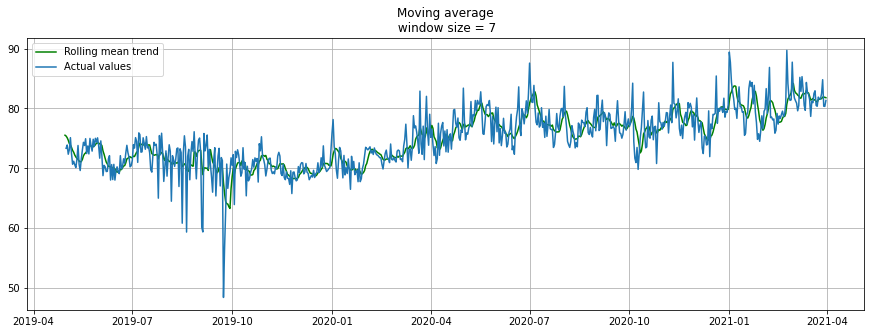

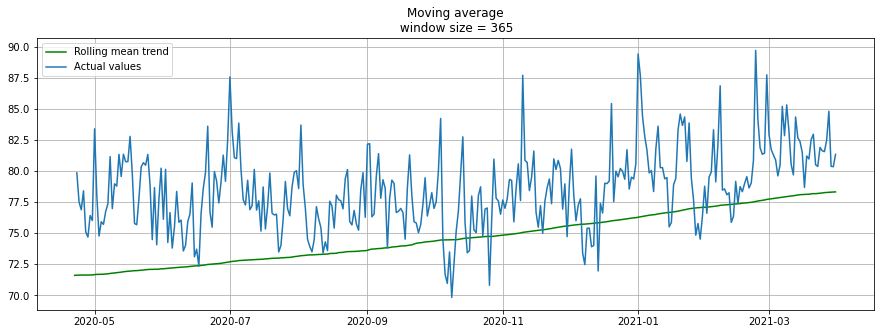

In [79]:
plotMovingAverage(df_pasta, 7)
plotMovingAverage(df_pasta, 365)

In [80]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

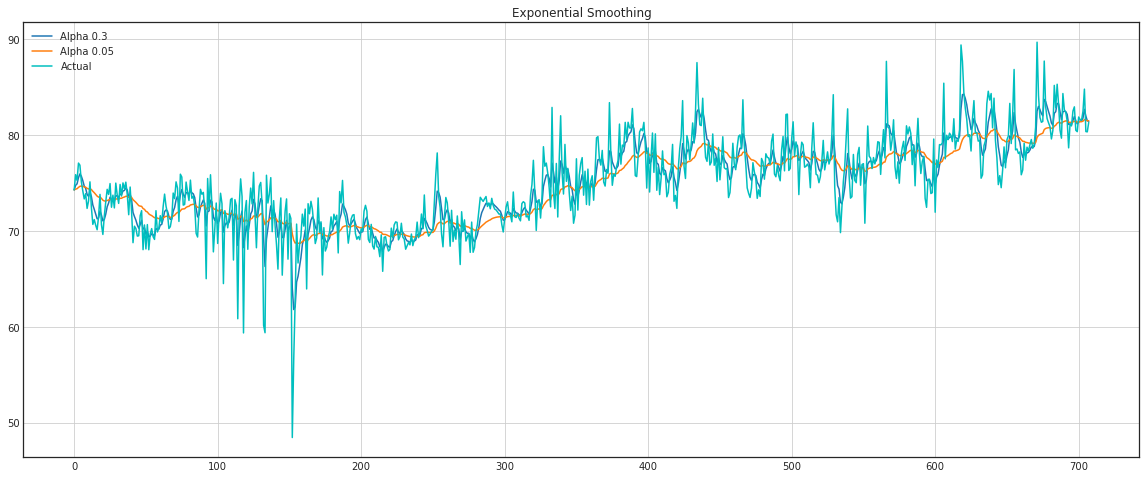

In [81]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(df_pasta.pasta, alpha), label="Alpha {}".format(alpha))
    plt.plot(df_pasta.pasta.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [82]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

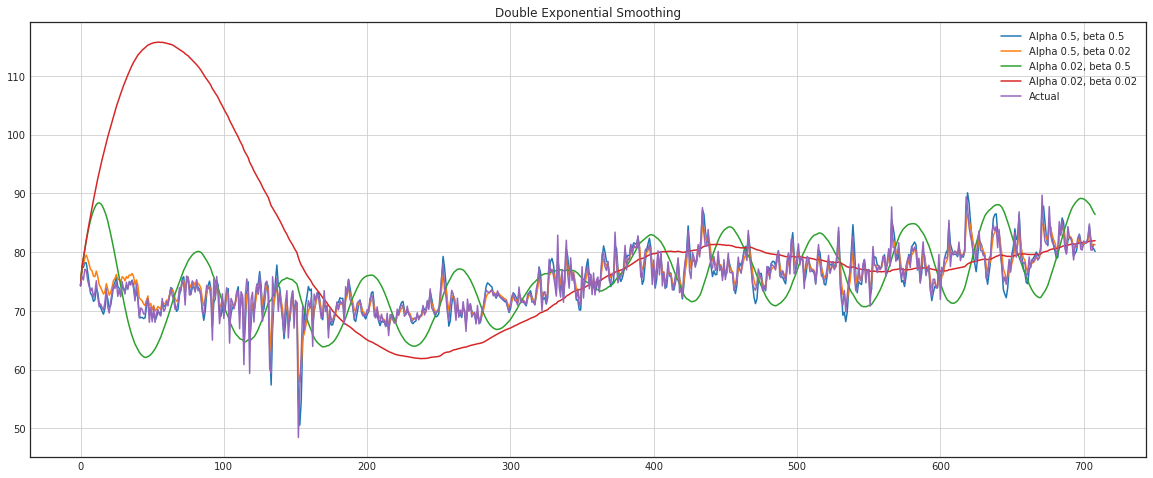

In [83]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.5, 0.02]:
        for beta in [0.5, 0.02]:
            plt.plot(double_exponential_smoothing(df_pasta.pasta, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df_pasta.pasta.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [84]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [85]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [86]:
%%time
data = df_pasta.pasta[:-100] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.023507206567979166 0.0534468194161814 0.0
Wall time: 2.59 s


In [87]:
# Передаем оптимальные значения модели, 
data = df_pasta.pasta
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

708


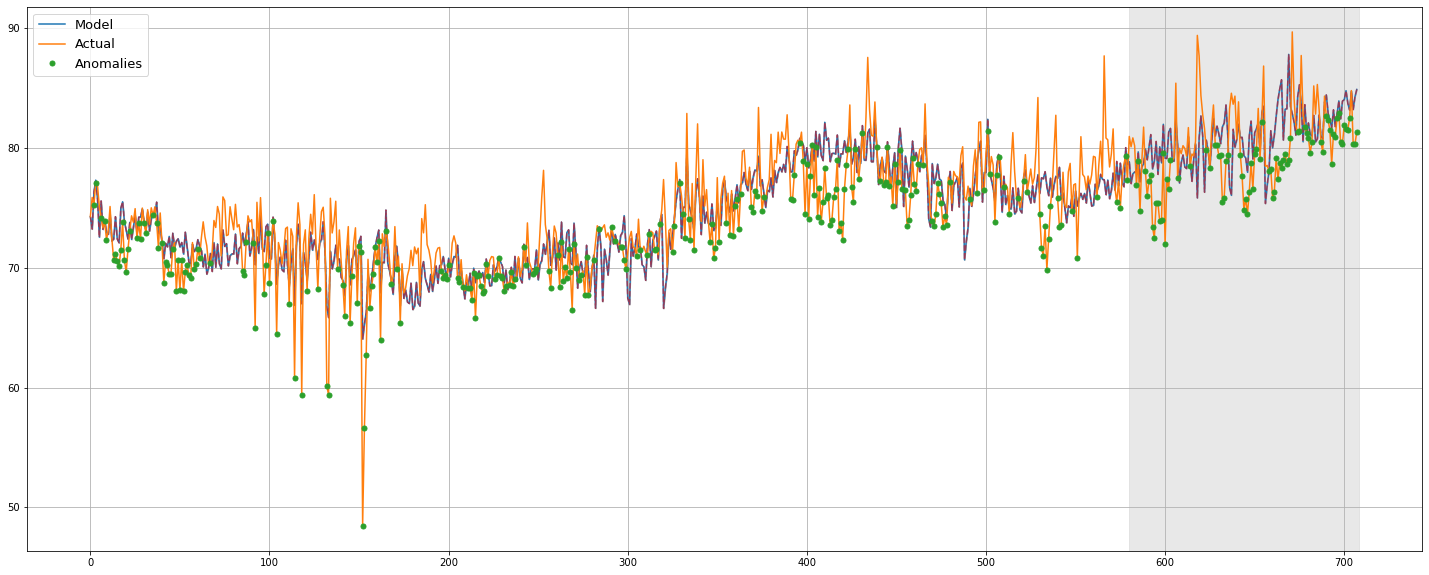

In [88]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    #plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=5, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    print(len(Anomalies))

plotHoltWinters()

In [89]:
Anomalies

NameError: name 'Anomalies' is not defined

In [ ]:
df_pasta.min()

In [90]:
data = df_pasta.pasta[:-100] # отложим часть данных для тестирования

In [91]:
dataset

Users
Time                      
2017-01-01 00:00:00  34002
2017-01-01 01:00:00  37947
2017-01-01 02:00:00  41517
2017-01-01 03:00:00  44476
2017-01-01 04:00:00  46234
...                    ...
2017-04-20 05:00:00  34833
2017-04-20 06:00:00  35932
2017-04-20 07:00:00  38418
2017-04-20 08:00:00  40238
2017-04-20 09:00:00  40763

[2625 rows x 1 columns]

In [92]:
dataset = pd.read_csv('hours-online.csv', index_col=['Time'], parse_dates=['Time'])

In [93]:
df_train.columns[4:]

Index(['pasta', 'legumes', 'bread', 'flour', 'rice', 'groats', 'potatoes',
       'сucumbers_tomatoes', 'vegetables', 'roots', 'сabbage', 'fruit',
       'sugar', 'candy', 'biscuits', 'mutton', 'beef', 'chicken', 'pork',
       'fish', 'herring', 'curd', 'sour_creame', 'butter', 'milk_kefir',
       'cheese', 'egg', 'margarine', 'oil', 'salt', 'spice', 'tea', 'cpi_1',
       'cpi_2', 'cpi_3', 'pasta_value', 'legumes_value', 'bread_value',
       'flour_value', 'rice_value', 'groats_value', 'potatoes_value',
       'сucumbers_tomatoes_value', 'vegetables_value', 'roots_value',
       'сabbage_value', 'fruit_value', 'sugar_value', 'candy_value',
       'biscuits_value', 'mutton_value', 'beef_value', 'chicken_value',
       'pork_value', 'fish_value', 'herring_value', 'curd_value',
       'sour_creame_value', 'butter_value', 'milk_kefir_value', 'cheese_value',
       'egg_value', 'margarine_value', 'oil_value', 'salt_value',
       'spice_value', 'tea_value', 'ai92', 'ai95', 'ai98', 'dt',

In [94]:
df_train

region        oktmo        okato       date   pasta  legumes   bread  \
0          72  71000000000  71000000000 2021-03-31   86.36   108.63   75.10   
1          75  76000000000  76000000000 2021-03-31   83.48   123.53   73.87   
2          74  75000000000  75000000000 2021-03-31   75.59   103.61   81.43   
3          73  73000000000  73000000000 2021-03-31   73.77    87.81   76.34   
4          65  64000000000  64000000000 2021-03-31  132.15   123.60  109.73   
...       ...          ...          ...        ...     ...      ...     ...   
60188      77  45000000000  45000000000 2019-04-23  113.15   122.36   87.90   
60189      79  99000000000  99000000000 2019-04-23   65.44    99.11   72.33   
60190      83  11800000000  11100000000 2019-04-23  101.84   170.51   71.96   
60191      78  40000000000  40000000000 2019-04-23   88.65   110.52  101.44   
60192      54  50000000000  50000000000 2019-04-23   68.10    87.81   63.27   

       flour    rice  groats  potatoes  сucumbers_tomatoes  vegetables  roots  \
0      34.06   81.14   65.37     43.83              142.83       33.99  65.91   
1      42.34   65.98   50.66     50.86              189.45       37.05  66.51   
2      33.27   77.01   70.49     39.78              141.62       34.11  67.62   
3      32.33   72.69   69.96     38.12              130.84       25.51  56.51   
4      50.71   24.65   20.25     42.23              183.08       56.22  56.38   
...      ...     ...     ...       ...                 ...         ...    ...   
60188  38.23   92.69   67.55     36.68              195.14       46.08  66.46   
60189  30.52   54.67   35.67     33.81              152.08       41.40  61.35   
60190   0.00  103.79   84.96     52.49              289.35       64.26  76.94   
60191  35.46   82.80   60.47     31.99              175.46       40.14  56.98   
60192  27.84   70.36   47.01     19.38              147.65       32.95  58.09   

       сabbage  fruit  sugar   candy  biscuits  mutton    beef  chicken  \
0        27.23   97.2  45.94  290.59    182.61    0.00  396.89   171.12   
1        33.59  134.2  50.61  226.55    178.15    0.00  277.68   182.51   
2        23.93   94.2  46.51  288.54    137.63  297.06  345.96   169.86   
3        18.93   87.2  44.13  274.46    166.64    0.00  319.04   166.56   
4        59.90  190.8  16.20  391.74    302.58    0.00  492.83   254.26   
...        ...    ...    ...     ...       ...     ...     ...      ...   
60188    65.90   88.0  42.94  384.50    226.56  453.75  484.88   203.72   
60189    49.09  120.8  48.96  276.83    194.66    0.00    0.00   188.45   
60190    84.50  142.2  60.01  433.83    248.68    0.00    0.00   263.24   
60191    64.90   82.4  41.97  340.60    200.00  417.53  394.95   192.09   
60192    55.71   89.3  46.29  297.65    167.13  321.18  329.60   167.66   

         pork    fish  herring    curd  sour_creame  butter  milk_kefir  \
0      251.04  422.55   211.48  271.26       190.73  473.74       52.21   
1      269.61  518.62   241.57  332.37       235.74  514.16       63.21   
2      244.00  298.66   179.46  277.84       184.06  421.86       55.50   
3      221.58  390.08   267.03  235.90       168.87  452.39       55.12   
4      334.01  340.94   320.56  464.63       376.05  745.15       79.74   
...       ...     ...      ...     ...          ...     ...         ...   
60188  279.57  619.67   310.35  299.08       205.28  602.60       65.25   
60189  296.06    0.00   220.59  374.97       219.79  618.35       64.37   
60190    0.00    0.00     0.00  170.39       297.28  661.07       86.02   
60191  267.59  503.61   264.54  279.47       174.30  606.89       61.27   
60192  256.07  297.86   209.36  257.47       135.29  459.38       52.37   

       cheese   egg  margarine     oil   salt  spice     tea    cpi_1  \
0      542.24  7.54     137.39  113.56  18.47  37.06   82.58  5807.71   
1      517.17  8.25     115.14  118.13  17.90  32.71   83.57  6312.35   
2      497.22  7.22     139.95  107.72  16.52  35.88   75.55  55

In [95]:
i = 0
for item in df_train.columns[4:]:
    df = df_train[(df_train['region'] == 63)][['{}'.format(item),'date']].sort_values('date')
    df = df.set_index('date')

    plotly_df(df, title = 'iter = {i},\n column = {item},\n region = 63'.format(item = item, i = i))
    i+=1

In [121]:
df_pasta = df_train[(df_train['region'] == 63)][['pasta','date']].sort_values('date')
df_pasta = df_pasta.set_index('date')

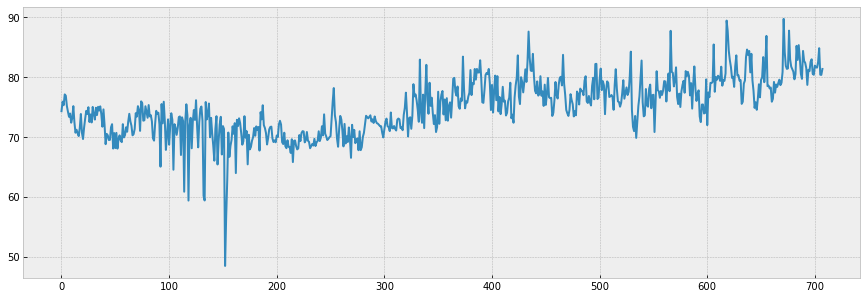

In [97]:
white_noise = df_pasta.pasta.values
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

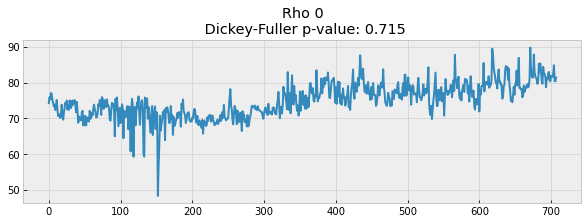

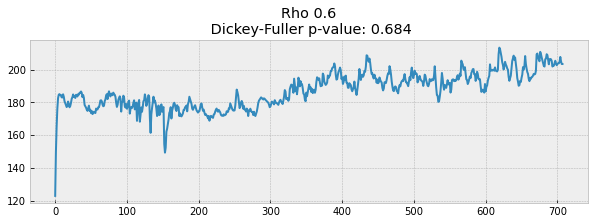

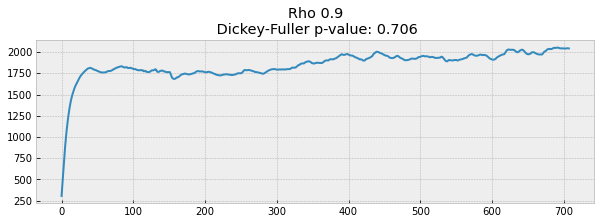

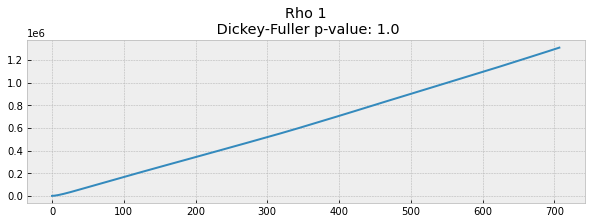

In [98]:
def plotProcess(n_samples=708, rho=0):
    x = w = white_noise
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

Критерий Дики-Фуллера: p=1.000000


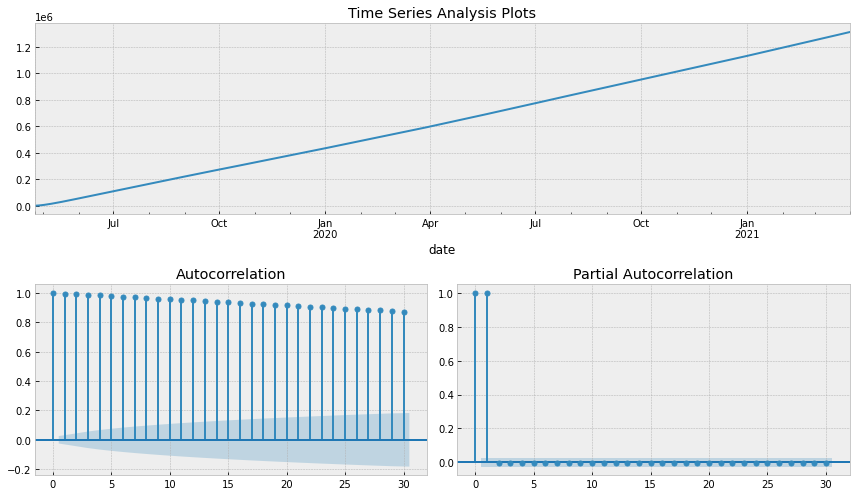

In [99]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df_pasta.pasta, lags=30)

Критерий Дики-Фуллера: p=0.713580
Оптимальный параметр преобразования Бокса-Кокса: 1.796190


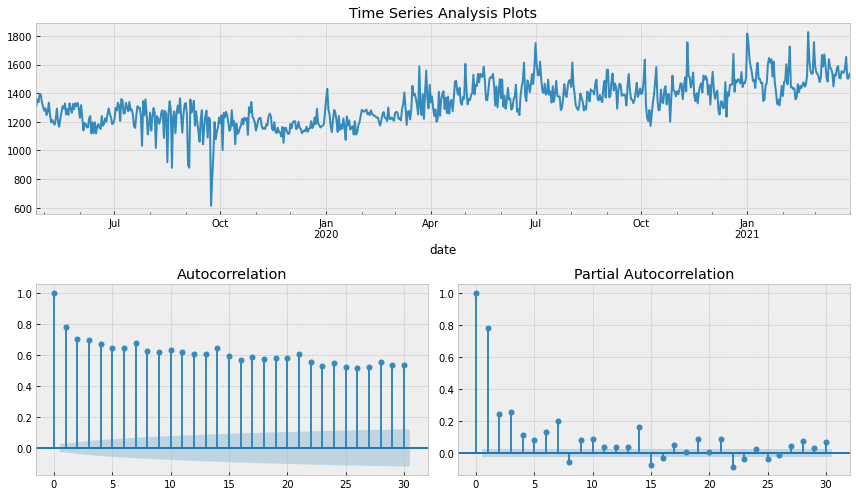

In [141]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = df_pasta.copy()
data['pasta'], lmbda = scs.boxcox(df_pasta.pasta+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.pasta, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000041


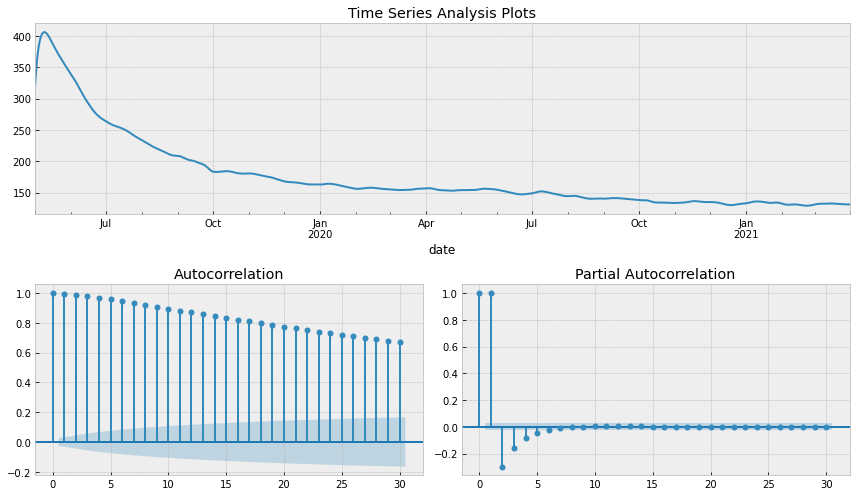

In [101]:
data['pasta_season7'] = data['pasta'] - data['pasta'].shift(7)
tsplot(data.pasta_season7[7:], lags=30)

Критерий Дики-Фуллера: p=0.000029


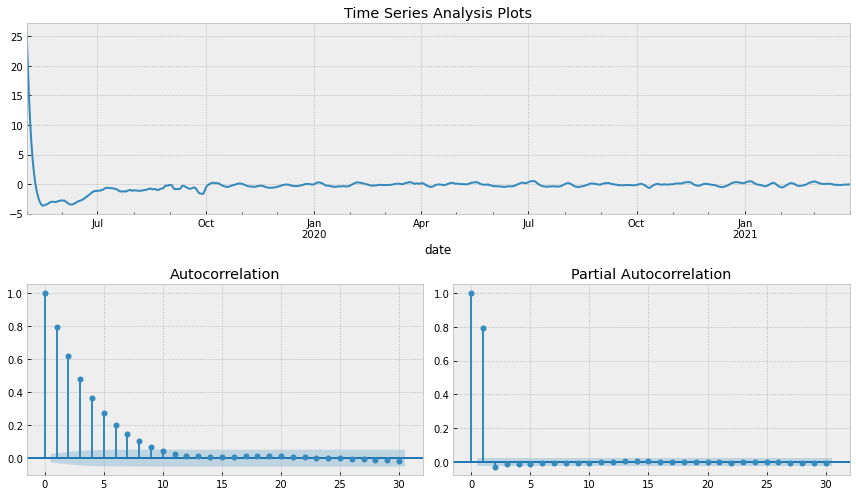

In [102]:
data['pasta_season7_diff'] = data.pasta_season7 - data.pasta_season7.shift(1)
tsplot(data.pasta_season7_diff[7+1:], lags=30)

In [103]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [104]:
%%time
results = []
best_aic = float("inf")

for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['pasta'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 31)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


      parameters          aic
84  (4, 0, 4, 0) -1756.802898
83  (4, 0, 3, 0) -1731.389532
64  (3, 0, 4, 0) -1713.854312
67  (3, 1, 2, 0) -1712.737164
89  (4, 1, 4, 0) -1712.498259
Wall time: 51min 44s


In [107]:
best_result = result_table.sort_values(by = 'aic', ascending=True)['parameters'].values[0]
best_result

(4, 0, 4, 0)

In [131]:
data['pasta']

date
2019-04-24    74.29
2019-04-25    75.88
2019-04-26    75.28
2019-04-27    77.09
2019-04-28    76.87
              ...  
2021-03-27    82.49
2021-03-28    84.81
2021-03-29    80.38
2021-03-30    80.35
2021-03-31    81.34
Name: pasta, Length: 708, dtype: float64

In [142]:
%%time
# set the parameters that give the lowest AIC
p, q, P, Q = best_result

best_model = sm.tsa.statespace.SARIMAX(
    data['pasta'], order=(p, d, q), seasonal_order=(P, D, Q, 31)
).fit(disp=-1)
print(best_model.summary())

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                              pasta   No. Observations:                  708
Model:             SARIMAX(4, 1, 0)x(4, 1, 0, 31)   Log Likelihood               -4055.954
Date:                            Sun, 25 Jul 2021   AIC                           8129.908
Time:                                    18:50:19   BIC                           8170.554
Sample:                                04-24-2019   HQIC                          8145.645
                                     - 03-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5006      0.033    -15.049      0.000      -0.566      -0.435
ar.L2         -0.4303      0.038   

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Критерий Дики-Фуллера: p=0.000000


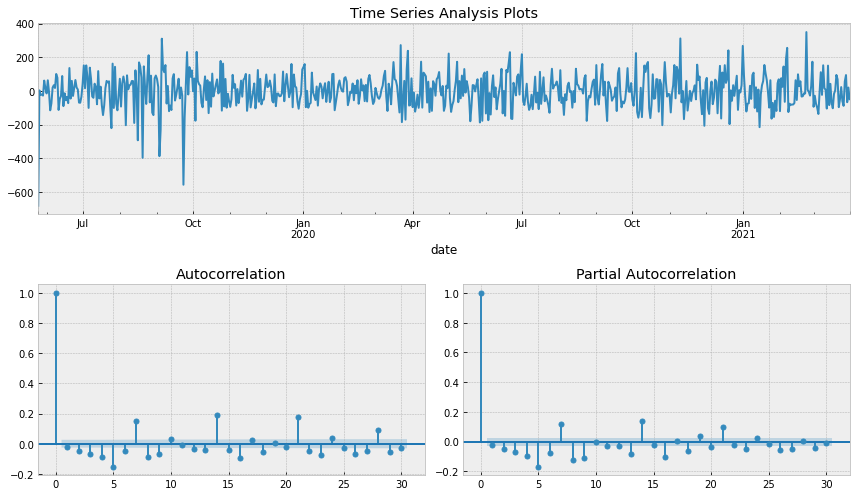

In [143]:
tsplot(best_model.resid[31:], lags=30)

In [134]:
data["arima_model"]

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



date
2019-04-24      1.000000
2019-04-25    358.960720
2019-04-26    370.315091
2019-04-27    366.018155
2019-04-28    379.034962
                 ...    
2021-03-27    406.008075
2021-03-28    416.115224
2021-03-29    417.907206
2021-03-30    396.907172
2021-03-31    421.102438
Name: arima_model, Length: 708, dtype: float64

In [135]:
df_pasta.pasta

date
2019-04-24    74.29
2019-04-25    75.88
2019-04-26    75.28
2019-04-27    77.09
2019-04-28    76.87
              ...  
2021-03-27    82.49
2021-03-28    84.81
2021-03-29    80.38
2021-03-30    80.35
2021-03-31    81.34
Name: pasta, Length: 708, dtype: float64

In [124]:
data['pasta'] = df_pasta.pasta

In [117]:
len(forecast)
data.shape[0]

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



708

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



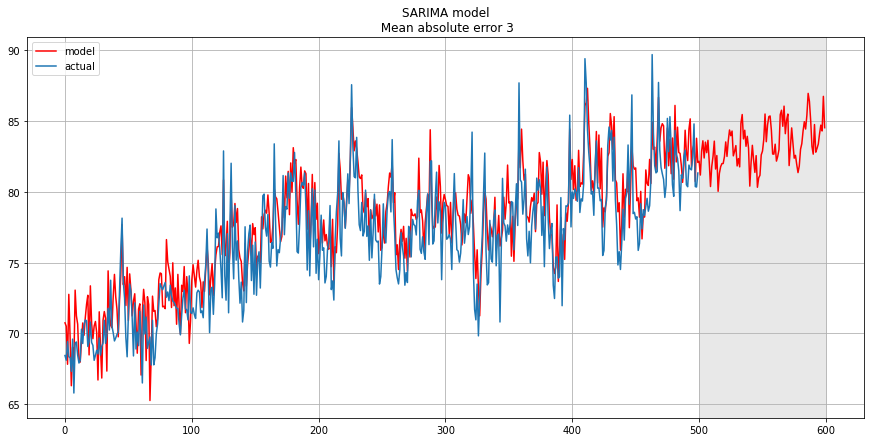

In [151]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-600:]
actual = data.pasta.values[-500:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {}".format(round(mean_absolute_error(data.dropna().pasta, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [149]:
df_pasta.pasta

date
2019-04-24    74.29
2019-04-25    75.88
2019-04-26    75.28
2019-04-27    77.09
2019-04-28    76.87
              ...  
2021-03-27    82.49
2021-03-28    84.81
2021-03-29    80.38
2021-03-30    80.35
2021-03-31    81.34
Name: pasta, Length: 708, dtype: float64

In [148]:
data.pasta = df_pasta.pasta

C:\Users\Kovardakov_VA\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [150]:
data

pasta  arima_model
date                          
2019-04-24  74.29     1.000000
2019-04-25  75.88    75.159400
2019-04-26  75.28    76.800327
2019-04-27  77.09    76.300866
2019-04-28  76.87    78.083131
...           ...          ...
2021-03-27  82.49    81.806223
2021-03-28  84.81    83.053553
2021-03-29  80.38    83.375365
2021-03-30  80.35    80.742254
2021-03-31  81.34    83.795683

[708 rows x 2 columns]

In [ ]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data['pasta'], order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)
print(best_model.summary())